In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/MyDrive/Deep Learning - CNN /Pneumonia Detection Using CNN-DL/X-ray/chest_xray"

# Imports, seeds, and quick sanity checks

Step 1 — Imports, seeds, and quick sanity checks

Import libraries we’ll use.

Set random seeds for reproducibility.

Define folder paths and print class counts so we know what we’re working with.

In [ ]:
import os, random, glob, math, numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from collections import Counter

# Reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

for p in [train_dir, val_dir, test_dir]:
    if not os.path.isdir(p):
        raise FileNotFoundError(f"Path not found: {p}\nPlease check base_dir above.")

# Count images per class in each split
def count_images(folder):
    counts = {}
    for cls in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(folder, cls)
        counts[cls] = len(glob.glob(os.path.join(path, "*")))
    return counts

print("Train counts:", count_images(train_dir))
print("Val counts  :", count_images(val_dir))
print("Test counts :", count_images(test_dir))


Train counts: {'NORMAL': 1371, 'PNEUMONIA': 3905}
Val counts  : {'NORMAL': 8, 'PNEUMONIA': 8}
Test counts : {'NORMAL': 234, 'PNEUMONIA': 400}


# Build data pipelines

Step 2 — Build data pipelines (load + augment images)
Convert images into batches for the model.

Augment only training images (random transformations) to improve generalization.

Rescale pixel values from [0,255] → [0,1].

Input size: 224×224 (common for CNNs and works well with medical images).

In [ ]:
# Step 2 — Build data pipelines (updated augmentation)
IMG_SIZE   = (224, 224)   # keep as you had
BATCH_SIZE = 32           # keep same for stability; increase only if GPU mem allows

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 5276 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 634 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


# Visualize a few samples

Step 3 — Visualize a few samples

Quick visual check to ensure labels and augmentation look sensible.

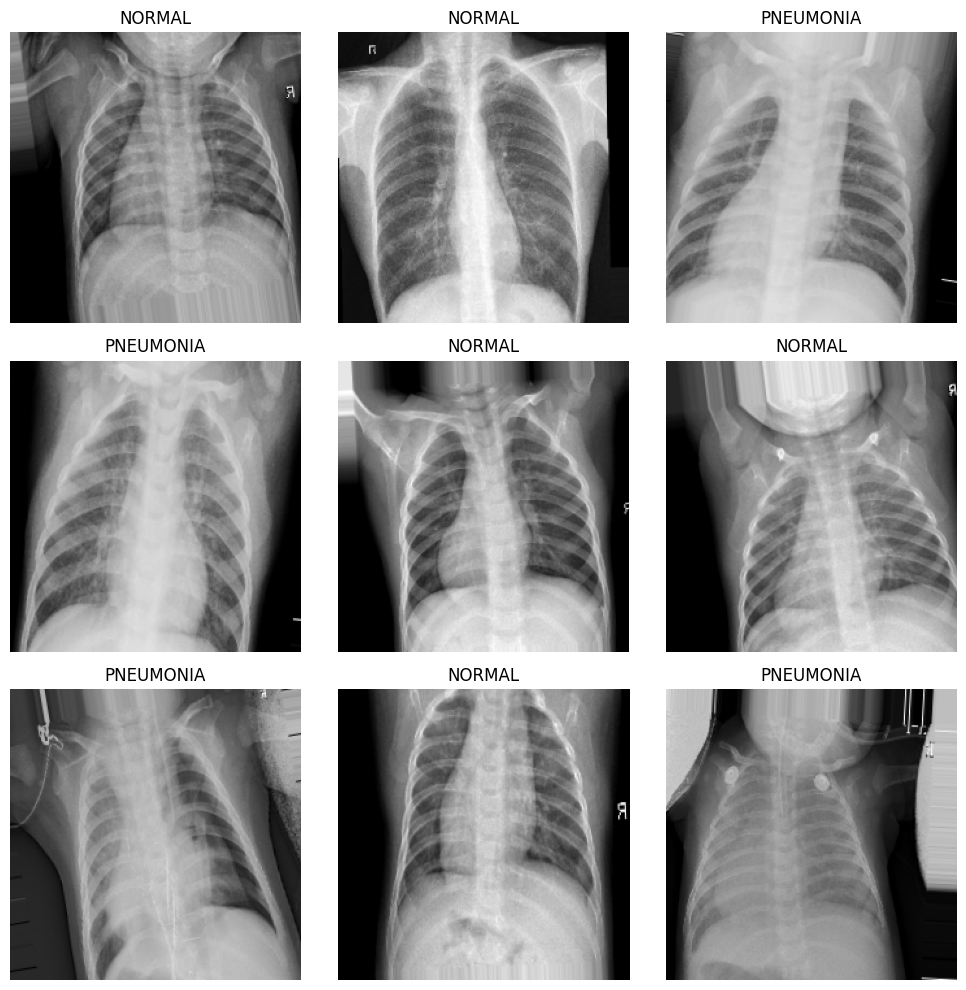

In [ ]:
imgs, labels = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(imgs[i])
    cls = "PNEUMONIA" if labels[i] == 1 else "NORMAL"
    plt.title(cls)
    plt.axis("off")
plt.tight_layout()
plt.show()


# Handle class imbalance with class weights

Step 4 — Handle class imbalance with class weights

X-ray sets are often imbalanced (usually more pneumonia than normal).

We compute class weights to make the model pay fair attention to both classes.


In [ ]:
# Derive class counts from the training generator
train_labels = train_gen.classes  # 0/1 labels for each training image
counts = Counter(train_labels)
total = counts[0] + counts[1]
w0 = total / (2.0 * counts[0])   # weight for class 0 (NORMAL)
w1 = total / (2.0 * counts[1])   # weight for class 1 (PNEUMONIA)
class_weights = {0: w0, 1: w1}
print("Class weights:", class_weights)


Class weights: {0: 1.9241429613420862, 1: 0.6755441741357234}


# Build a clean CNN

Step 5 — Build a clean CNN (from scratch)

A simple yet strong CNN: Conv → BN → ReLU → Pool (x3), then Dense layers.

Dropout helps prevent overfitting; BatchNormalization stabilizes training.

Last layer uses sigmoid for binary (pneumonia vs normal).

In [ ]:
from tensorflow.keras import layers, models, regularizers

def build_cnn(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3,3), padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 4
    x = layers.Conv2D(256, (3,3), padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="PneumoniaCNN")
    return model

# Build model
model = build_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.summary()


Model: "PneumoniaCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

# Compile the model Set loss to binary_crossentropy

Step 6 — Compile the model
Set loss to binary_crossentropy (binary classification).

Use Adam optimizer.

Track metrics: accuracy, precision, recall, AUC (useful in medical tasks).

In [ ]:
# Step 6 — Compile model (lower LR)
import math
from tensorflow.keras.optimizers import Adam

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-4),   # lowered from 1e-3
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)


# Train with callback

Step 7 — Train with callbacks (best checkpoint + early stopping)
ModelCheckpoint: save best validation model.

EarlyStopping: stop when validation loss doesn’t improve.

ReduceLROnPlateau: lower LR if training plateaus.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

ckpt_path = "pneumonia_cnn_best.keras"

callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

steps_per_epoch   = math.ceil(train_gen.samples / BATCH_SIZE)
validation_steps  = math.ceil(val_gen.samples / BATCH_SIZE)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=30,
    class_weight=class_weights,   # comment this out if your classes are balanced
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7392 - auc: 0.8066 - loss: 0.5743 - precision: 0.8902 - recall: 0.7355 
Epoch 1: val_loss improved from inf to 3.23986, saving model to pneumonia_cnn_best.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 1726s 10s/step - accuracy: 0.7396 - auc: 0.8071 - loss: 0.5735 - precision: 0.8905 - recall: 0.7358 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 3.2399 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.8729 - auc: 0.9427 - loss: 0.3163 - precision: 0.9749 - recall: 0.8510
Epoch 2: val_loss did not improve from 3.23986
165/165 ━━━━━━━━━━━━━━━━━━━━ 120s 731ms/step - accuracy: 0.8729 - auc: 0.9427 - loss: 0.3162 - precision: 0.9749 - recall: 0.8511 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 5.3032 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accura

# Plot training curves

Step 8 — Plot training curves (loss & metrics)

Visualize how training progressed to check for over/underfitting.

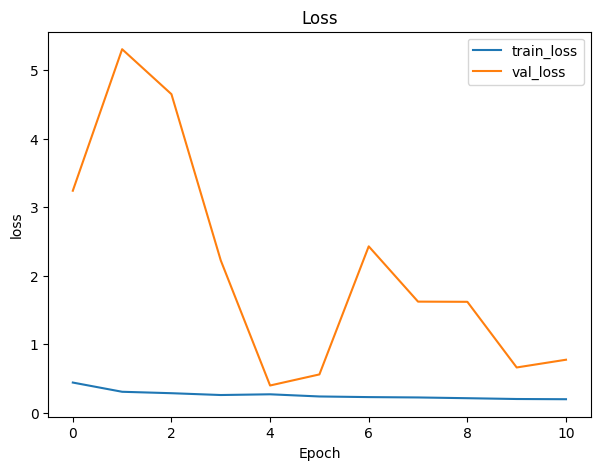

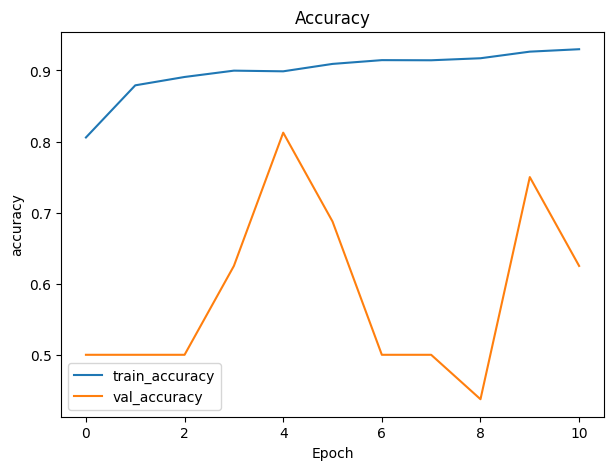

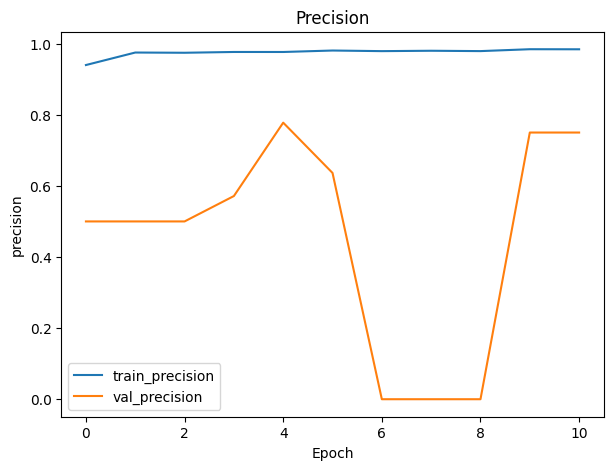

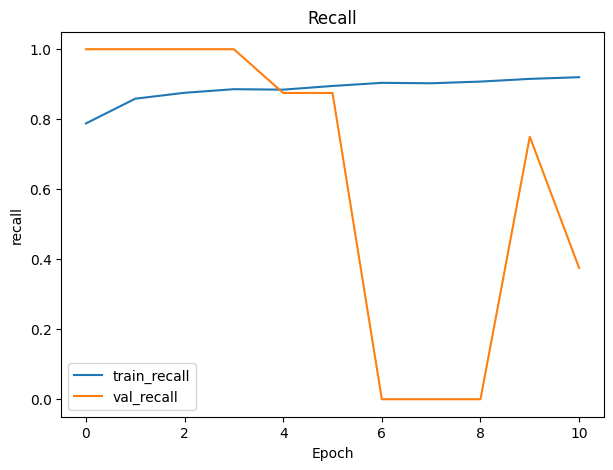

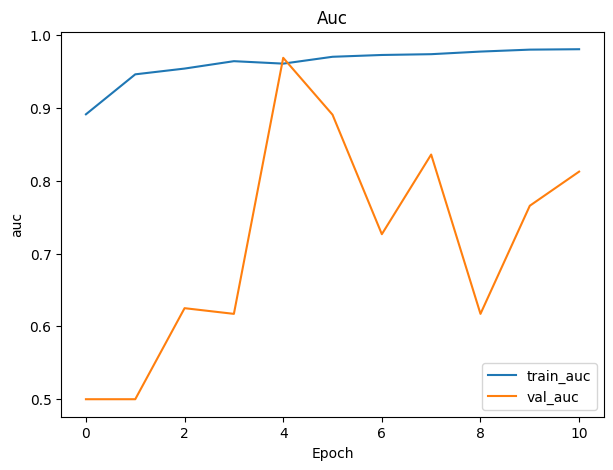

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
    for metric in metrics:
        plt.figure(figsize=(7,5))
        plt.plot(history.history[metric], label=f'train_{metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.show()

# Call the function
plot_metrics(history)


# Model Evaluate

Step 9 — Evaluate on the independent test set
Load the best checkpoint and evaluate on images the model never saw.

Show accuracy, precision, recall, AUC, confusion matrix, classification report, and ROC curve.

20/20 ━━━━━━━━━━━━━━━━━━━━ 223s 12s/step - accuracy: 0.7961 - auc: 0.6048 - loss: 0.4887 - precision: 0.4612 - recall: 0.5810

Test metrics (loss, acc, precision, recall, AUC):
 [0.39547133445739746, 0.8328076004981995, 0.8500000238418579, 0.8924999833106995, 0.9116880297660828]
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.80      0.73      0.76       234
   PNEUMONIA       0.85      0.89      0.87       400

    accuracy                           0.83       634
   macro avg       0.82      0.81      0.82       634
weighted avg       0.83      0.83      0.83       634



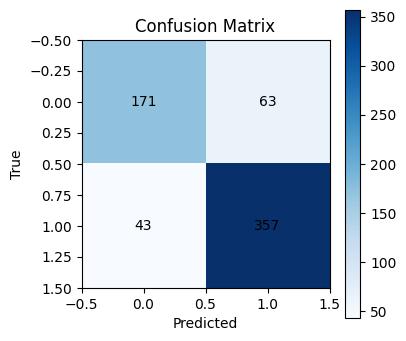

ROC-AUC: 0.9115811965811966


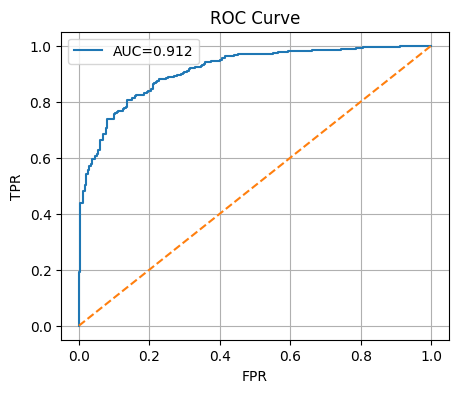

In [16]:
best_model = tf.keras.models.load_model(ckpt_path)

test_steps = math.ceil(test_gen.samples / BATCH_SIZE)
test_metrics = best_model.evaluate(test_gen, steps=test_steps, verbose=1)
print("\nTest metrics (loss, acc, precision, recall, AUC):\n", test_metrics)

# Predictions for detailed metrics
test_gen.reset()
probs = best_model.predict(test_gen, steps=test_steps, verbose=1).ravel()
preds = (probs >= 0.5).astype(int)
y_true = test_gen.classes

print("\nClassification Report:\n")
print(classification_report(y_true, preds, target_names=["NORMAL","PNEUMONIA"]))

cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.colorbar(); plt.show()

auc = roc_auc_score(y_true, probs)
fpr, tpr, _ = roc_curve(y_true, probs)
print("ROC-AUC:", auc)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
plt.legend(); plt.grid(True); plt.show()


# Grad-CAM

Step 10 — Grad-CAM (see what the model focuses on)
Generate heatmaps to visualize important regions in the chest X-ray for the model’s decision.

This improves interpretability for clinicians and presentations.

Using conv layer for Grad-CAM: conv2d_3


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


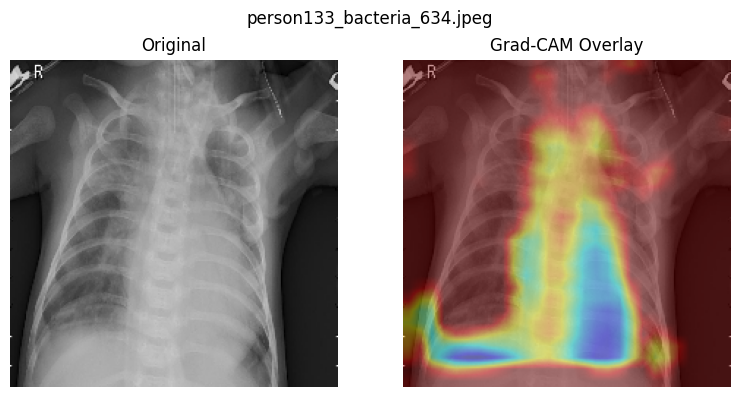

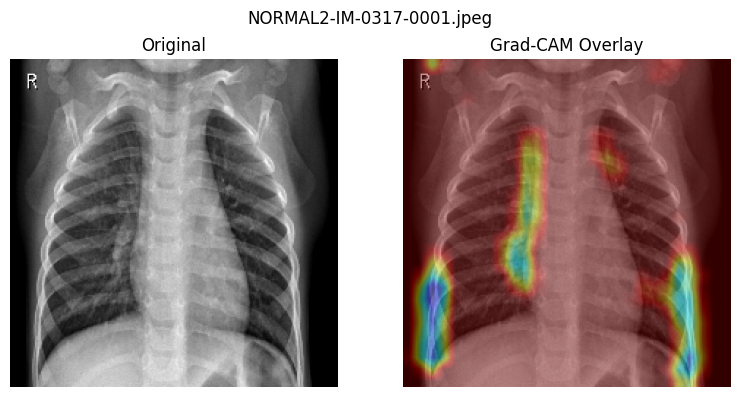

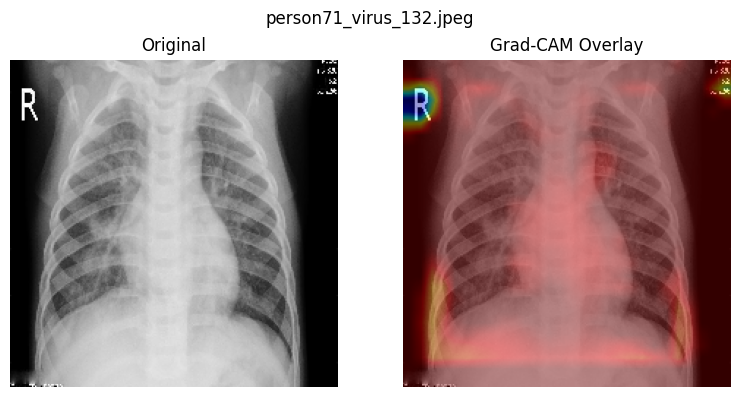

In [17]:
import cv2

# Pick a conv layer name from model.summary(); typically the last Conv2D
last_conv_layer_name = None
for layer in reversed(best_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print("Using conv layer for Grad-CAM:", last_conv_layer_name)

def grad_cam(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap

# Visualize 3 test images with Grad-CAM
import itertools
test_paths = []
for cls in ["NORMAL", "PNEUMONIA"]:
    test_paths += list(glob.glob(os.path.join(test_dir, cls, "*")))
random.shuffle(test_paths)
test_paths = test_paths[:3]

for p in test_paths:
    # load + preprocess
    img = tf.keras.utils.load_img(p, target_size=IMG_SIZE)
    arr = tf.keras.utils.img_to_array(img)/255.0
    inp = np.expand_dims(arr, axis=0)

    heatmap = grad_cam(best_model, inp, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, IMG_SIZE[::-1])
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # overlay
    original = (arr * 255).astype("uint8")
    overlay = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(8,4))
    plt.suptitle(os.path.basename(p))
    plt.subplot(1,2,1); plt.imshow(original); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay);  plt.title("Grad-CAM Overlay"); plt.axis("off")
    plt.tight_layout(); plt.show()


# Predict on a single image

Step 11 — Predict on a single image (for demo/clinical use)
Load an image, run prediction, convert probability → label.

In [30]:
import matplotlib.pyplot as plt

def predict_and_show(path):
    # 1. Load and preprocess the image
    img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)
    arr = tf.keras.utils.img_to_array(img)/255.0

    # 2. Model prediction
    prob = float(best_model.predict(np.expand_dims(arr, 0))[0][0])
    label = "PNEUMONIA" if prob >= 0.5 else "NORMAL"

    # 3. Show the image with prediction result
    plt.imshow(arr)
    plt.axis("off")
    plt.title(f"Prediction: {label}\nProbability: {prob:.4f}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


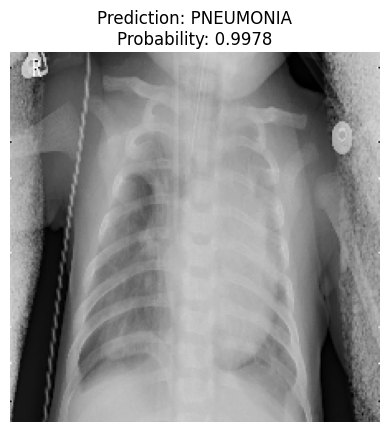

In [32]:
predict_and_show("/content/drive/MyDrive/Deep Learning - CNN /Pneumonia Detection Using CNN-DL/X-ray/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


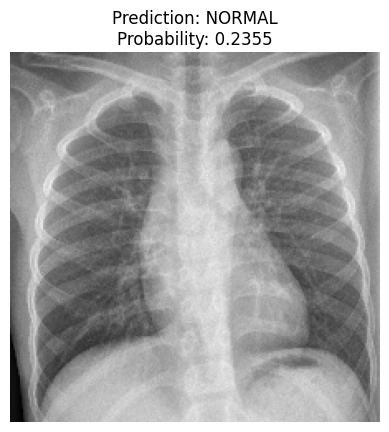

In [34]:
predict_and_show("/content/drive/MyDrive/Deep Learning - CNN /Pneumonia Detection Using CNN-DL/X-ray/chest_xray/test/NORMAL/IM-0006-0001.jpeg")